# Simulating Chutes & Ladders in Python

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2017/12/18/simulating-chutes-and-ladders/) on the blog [Pythonic Perambulations](http://jakevdp.github.io).*

<!-- PELICAN_BEGIN_SUMMARY -->

<img src="http://jakevdp.github.io/images/ChutesAndLadders-sim.gif" alt='[img: Chutes and Ladders animated simulation]'>

This weekend I found myself in a particularly drawn-out game of Chutes and Ladders with my four-year-old. If you've not had the pleasure of playing it, Chutes and Ladders (also sometimes known as Snakes and Ladders) is a classic kids board game wherein players roll a six-sided die to advance forward through 100 squares, using "ladders" to jump ahead, and avoiding "chutes" that send you backward. It's basically a glorified random walk with visual aids to help you build a narrative. Thrilling. But she's having fun practicing counting, learning to win and lose gracefully, and developing the requisite skills to be a [passionate sports fan](https://xkcd.com/904/), so I play along.

On the approximately twenty third game of the morning, as we found ourselves in a near endless cycle of climbing ladders and sliding down chutes, never quite reaching that final square to end the game, I started wondering how much longer the game could last: what is the expected length of a game? How heavy are the tails of the game length distribution? How succinctly could I answer those questions in Python? And then, at some point, it [clicked](https://twitter.com/jakevdp/status/942456865580924928): Chutes and Ladders is memoryless — the effect of a roll depends only on where you are, not where you've been — and so it can be modeled as a Markov process! By the time we (finally) hit square 100, I basically had this blog post written, at least in my head.

When I [tweeted about this](https://twitter.com/jakevdp/status/942456865580924928), people pointed me to a [number](http://www.datagenetics.com/blog/november12011/) of [similar](https://gist.github.com/CamDavidsonPilon/1639d06c448904afaf7b7449910f3b72) [treatments](https://math.byu.edu/~jeffh/mathematics/games/chutes/chutes.html) of [Chutes](https://roycoding.github.io/chutes-ladders-d3/) & [Ladders](https://scipython.com/book/chapter-6-numpy/additional-problems/analysing-snakes-and-ladders-as-a-markov-chain/), so I'm under no illusion that this idea is original.
Think of this as a blog post version of dad joke: my primary goal is not originality, but self-entertainment, and if anyone else finds it entertaining that's just an added bonus.

<!-- PELICAN_END_SUMMARY -->

## Direct Simulation

The most straightforward way to get a handle on the dynamics of the game is through direct simulation: if we simulate enough games, we'll obtain a distribution of game lengths that will approximate the "true" distribution.
The first step in this is to examine the game board and somehow encode the positions of the chutes and ladders on the grid:

<img src='http://jakevdp.github.io/images/ChutesAndLadders-board.gif' width=400 alt='[img: Chutes and ladders game board]'/>

*(Image source: [uncyclopedia](http://uncyclopedia.wikia.com/wiki/Chutes_and_Ladders))*

We'll use a Python dictionary to store these positions:

In [1]:
# Mapping of start : end spaces of chutes & ladders
CHUTES_LADDERS = {1:38, 4:14, 9:31, 16:6, 21:42, 28:84, 36:44,
                  47:26, 49:11, 51:67, 56:53, 62:19, 64:60,
                  71:91, 80:100, 87:24, 93:73, 95:75, 98:78}

With this in place, we can simulate the game in a few lines of Python:

In [2]:
from random import Random


def simulate_cl_game(rseed=None, max_roll=6):
    """
    Simulate a full Chutes & Ladders game
    and return the number of turns to finish
    """
    rand = Random(rseed)
    position = 0
    turns = 0
    while position < 100:
        turns += 1
        roll = rand.randint(1, max_roll)
        
        # if the roll takes us past square 100, we don't move
        if position + roll > 100:
            continue
            
        # otherwise, move the position according to the roll
        position += roll
        
        # go up/down any chute/ladder
        position = CHUTES_LADDERS.get(position, position)
    return turns

Calling the function tells us how many moves were required to finish the particular game:

In [3]:
simulate_cl_game()

27

If we simulate many games, the result will be a distribution of how many turns are required to get to the end:

In [4]:
# Jupyter notebook plotting setup & imports
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

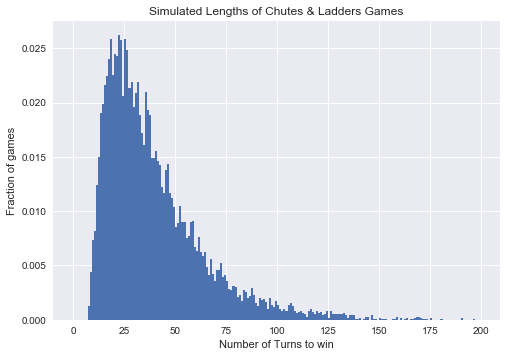

In [5]:
sim_games = [simulate_cl_game() for i in range(10000)]

plt.hist(sim_games, bins=range(200), normed=True)
plt.xlabel('Number of Turns to win')
plt.ylabel('Fraction of games')
plt.title('Simulated Lengths of Chutes & Ladders Games');

This gives us some insight, but the problem here is that the result is just an estimate of the "true" distribution; to make our estimate more precise will require many more simulations, and this can get computationally expensive.

Fortunately, there's another approach.

## Chutes and Ladders as a Markov Process

Instead of brute force simulation, we might think about the game probabilistically. On any given turn, there are six equally probable options: rolling a 1, 2, 3, 4, 5, or 6.
Depending on which space you start on, these lead to six well-defined results.
For example, the first turn, the possibilities are the squares 38, 2, 3, 14, 5, or 6, each with equal probability. We could encode this set of probabilities as a vector of length 101, with ``1/6`` in each associated index (here the zeroth element represents the start of the game, off of the board):

    0: [0, 0, 1/6, 1/6, 0, 1/6, 1/6, 0, 0, ...]
    
Each entry in this vector is the probability of going from square zero to the corresponding square. This vector *completely describes* the first turn of the game.

Similarly, we could construct the vector describing turns from square 1:

    1: [0, 0, 1/6, 1/6, 0, 1/6, 1/6, 1/6, 0, 0, ...]
    
Again, this completely describes any turn of the game that starts at square one.

The key insight is that Chutes and Ladders is *memoryless*; if you're on, say, square 19, it doesn't matter if you got there by sliding down from square 62, or by rolling a five from square 14 – the probabilities on the next turn are exactly the same.

This kind of situation: a sequence of probabilistic transitions from one state to another with no memory of previous states, is known as a [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain) or Markov Process,
and can be *entirely* described by a *N x N* transition matrix where *N* is the number of states in the system (101 states for Chutes and Ladders).
The columns of the matrix contain the probability vectors we discussed above, such that element *(n, m)* is the probability of transitioning to element *n* when starting from element *m*.

Let's create a Markov transition matrix for Chutes and Ladders:

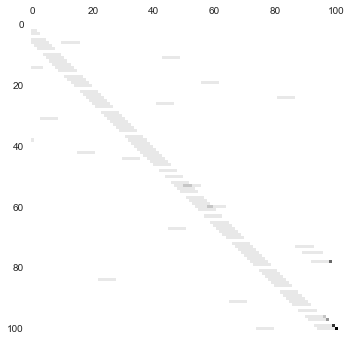

In [6]:
import numpy as np

def cl_markov_matrix(max_roll=6):
    """Create a Markov transition matrix"""  
    # Create the basic transition matrix:
    mat = np.zeros((101, 101))
    for i in range(101):
        mat[i + 1:i + 1 + max_roll, i] = 1. / max_roll
        
    # We could alternatively use scipy.linalg.circulent as follows:
    # mat = circulant([0, *np.ones(max_rolls) / 6, *np.zeros(100)])[:101, :101]

    # rolls off the end of the board don't change the state;
    # add these probabilities to the diagonal
    mat[range(101), range(101)] += 1 - mat.sum(0)

    # account for the presence of chutes and ladders
    # we'll do this via  another transition matrix
    cl_mat = np.zeros((101, 101))
    ind = [CHUTES_LADDERS.get(i, i) for i in range(101)]
    cl_mat[ind, range(101)] = 1
    return cl_mat @ mat

mat = cl_markov_matrix()
plt.matshow(mat)
plt.grid(False)

The above matrix encodes *everything you need to know* about the game of Chutes and Ladders. For efficiency, we could remove all rows and columns associated with the bottoms of ladders or the tops of chutes, as they are not valid states in the game, but for the ease of having indices match game board spaces, we'll leave them in.

The game starts with a state vector describing 100% probability of being in the zeroth state:

    v_0 = [1, 0, 0, 0, 0...]
    
If you think about it for a while, you can convince yourself that the way to evolve this (probabilistically) to the next state is to left-multiply the vector by our transition matrix:

In [7]:
np.set_printoptions(suppress=True, precision=3)

v_0 = [1, *np.zeros(100)]
mat @ v_0

array([ 0.   ,  0.   ,  0.167,  0.167,  0.   ,  0.167,  0.167,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.167,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.167,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ])

The result is precisely the vector we described above, encoding the probabilities of game state after one move.

To perform multiple moves, we could repeatedly multiply this vector by our transition matrix, but repeating such an operation can compound floating-point inaccuracies; a more effective (and more efficient) approach is to use a matrix power.
With this in mind, lets compute the probability of finishing the game in *n* moves for several values of *n*, and compare it to the simulation result from above:

In [8]:
def cl_probability(n):
    """Compute the state vector after n turns"""
    mat = cl_markov_matrix()
    v_0 = [1, *np.zeros(100)]
    return np.linalg.matrix_power(mat, n) @ v_0

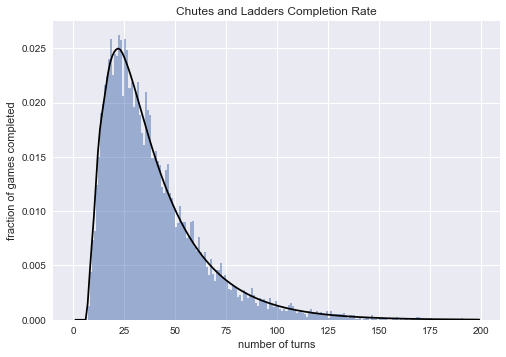

In [9]:
probs = [cl_probability(i)[-1] for i in range(200)]

plt.hist(sim_games, bins=range(200), normed=True,
         align='mid', alpha=0.5);
plt.plot(np.arange(1, 200), np.diff(probs), color='black')
plt.title('Chutes and Ladders Completion Rate')
plt.xlabel('number of turns')
plt.ylabel('fraction of games completed');

By eye it looks like our direct simulation was quite close to the Markov model, which indicates that we're on the right track in our thinking.

The cumulative distribution is also interesting:

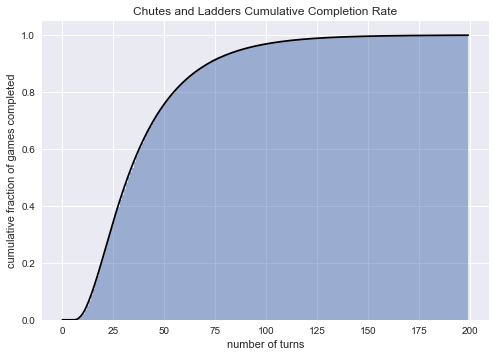

In [10]:
plt.hist(sim_games, bins=range(200), normed=True,
         align='mid', cumulative=True, alpha=0.5);
plt.plot(np.arange(200), probs, color='black');
plt.title('Chutes and Ladders Cumulative Completion Rate')
plt.xlabel('number of turns')
plt.ylabel('cumulative fraction of games completed');

From this, we can see that 90% of games finish within about 72 moves, though it is possible for games to be much longer.

With two players, this translates to a 1% chance that the game will go 72 moves without either of the players winning. Assuming roughly 15 seconds per round, that is about 18 minutes of play time, though from personal experience I can say it feels roughly twenty times that long.

### Minimum Game Length

But what if you get *really* lucky... how quickly can the game end?
From our Markov chain results, we see that there is a nonzero probability of finishing the game in just seven moves, and this will happen about once in every 660 games:

In [11]:
probs[1:8]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015110596707818924]

The Markov chain approach doesn't immediately tell us *how* this happens, though that could be determined with a bit of book-keeping to track *which* probabilities contribute to the result in question.

## Typical Game Length

We've talked about the extremes, but how long should you expect the typical game to last?
The answer to that question depends on what you mean by *typical*.
Some common approaches to defining *typical* are the mean, median, or mode of game lengths.

The mean game length is the expected value of the number of turns, averaged over all possibilities and weighted by their relative probability:

In [12]:
turns = np.arange(1, len(probs))
np.dot(np.diff(probs), turns)

39.106460290714438

We see that, on average, a player will finish the game in about 39 turns.

This value, though, is weighted by game length, so the small possibility of having a very long game contributes to this estimate in an outsized way.
Often the median game length is a more useful statistic:

In [13]:
np.searchsorted(probs, 0.5)

32

This tells us that approximately 50% of games will be finished in fewer than 32 moves, and 50% will be finished in more than 32 moves.

But both the mean and the median are offset from the peak (or mode) of the probability distribution, which we can compute as follows:

In [14]:
np.argmax(np.diff(probs)) + 1

22

This says that you'll finish the game in 22 moves more often than any other specific number of moves.

Probably the most useful types of statistics for skewed probability distributions like this one, though, are quantiles. For example:

In [15]:
np.searchsorted(probs, [0.025, 0.975])

array([ 11, 106])

This tells us that 95% of the time, games will last between 11 and 106 turns.
Or, to tighten the constraints a bit:

In [16]:
np.searchsorted(probs, [0.25, 0.75])

array([22, 50])

half of all games will last between 22 and 50 moves.

## Learning More from the Markov Process

Aside from summary statistics, the Markov transition matrix for Chutes and Ladders can tell us a number of other interesting things. For example, the eigenvectors of a transition matrix with eigenvalue equal to one tell us about *stationary states*; that is, states which are unchanged when applying the transition matrix.

We can compute these eigenvectors this way:

In [17]:
evals, evecs = np.linalg.eig(mat)
evals[:10]

array([ 1.000+0.j   ,  0.833+0.j   ,  0.960+0.j   ,  0.398+0.651j,
        0.398-0.651j,  0.755+0.j   ,  0.600+0.319j,  0.600-0.319j,
        0.240+0.589j,  0.240-0.589j])

There is only one stationary state in Chutes and Ladders (with eigenvalue equal to one); let's see what it is:

In [18]:
evecs[:, 0]

array([ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+

Graciously, the single stationary state is a completed game. What this means is that you are very unlikely to find yourself in an infinitely looping, unending game.
I doubt the game designers did this stationary state calculation when designing the game, but I bless them for their accidental success in this regard.

### Shannon Entropy

Another interesting thing we can explore is the [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory) of the distribution: you can think of the entropy as a measure of how "spread out" the distribution is in probability space; a high entropy state is one in which we have very little knowledge of where an individual draw will lie.

We can compute and visualize the entropy using the [``entropy``](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function from SciPy's ``stats`` module.
Let's plot the entropy as a function of the number of turns played:

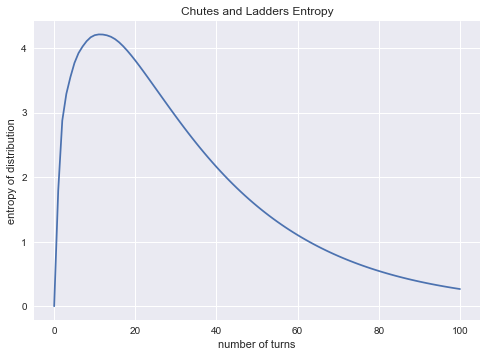

In [19]:
from scipy import stats

turns = np.arange(101)
entropy = [stats.entropy(cl_probability(turn)) for turn in turns]

plt.plot(turns, entropy)
plt.xlabel('number of turns')
plt.ylabel('entropy of distribution')
plt.title('Chutes and Ladders Entropy');

We see that the entropy is maximized after eleven turns:

In [20]:
np.argmax(entropy)

11

What this tells you is that after 11 turns, you should expect positions of various players to be very spread out. Prior to this, the probability distribution is clumped near the beginning of the board. After 11 moves, you can take heart that you're unavoidably on the path to the game's end.

## Visualizing the Board

Just for fun, let's use Python's tools to visualize these probability states in an intuitive way.
We'll use the above scan of the original Chutes and Ladders game as our background, and plot the probability distribution on top of this using a custom colormap with changing transparency

In [21]:
from matplotlib import colors

# Make a blue colorbar with increasing opacity
c = np.zeros((100, 4))
c[:, -1] = np.linspace(0, 1, 100)  # transparency gradient
c[:, 2] = 0.5  # make the map dark blue
TransparencyMap = colors.ListedColormap(c)


def show_board(turn):
    fig, ax = plt.subplots()
    board = plt.imread('ChutesAndLadders-board.gif')
    
    # Compute & reshape the probability vector
    prob = cl_probability(turn)
    prob = prob[1:].reshape(10, 10)[::-1]
    prob[::2] = prob[::2, ::-1]
    
    # Show result over the image of the board
    ax.imshow(board, alpha=0.8)
    im = ax.imshow(prob, extent=[10, 800, 810, 10],
                   norm=colors.LogNorm(vmin=1E-3, vmax=1),
                   cmap=TransparencyMap)
    fig.colorbar(im, ax=ax, label='Fraction of games')
    ax.axis('off')
    ax.set_title(f"Turn {turn}")
    
    return fig

Using this, we can visualize the probability distribution after any number of turns:

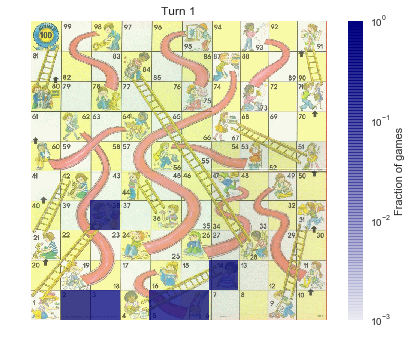

In [22]:
show_board(1);

After one turn, the distribution is quite tight: there are six possible states we can find ourselves in.

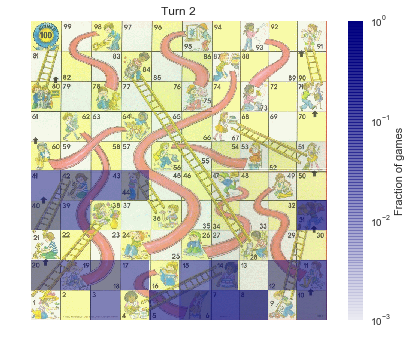

In [23]:
show_board(2);

After two turns, things become more spread out, though they are still clumped around a few more likely values.

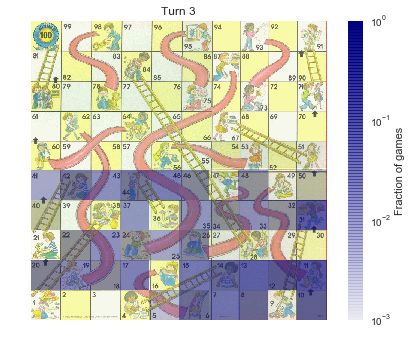

In [24]:
show_board(3);

After 3 turns, the distribution is getting even further apart.

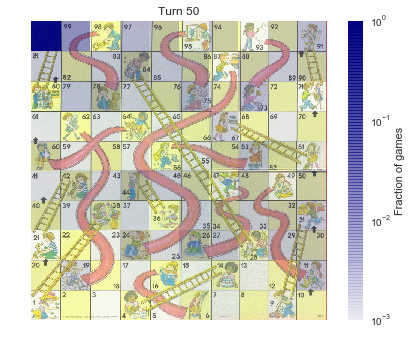

In [25]:
show_board(50);

After 50 turns, many games will be finished, but there's still a non-negligible probability of finding yourself in spaces across the board.

### Animating the Simulations

These board visualizations will be a bit more intuitive if we animate the results; here I'll do this using the excellent [ImageIO](http://imageio.github.io/) package to stitch together an animated GIF from the individual matplotlib plots.
(Note that you can also do this sort of animation [directly in matplotlib](http://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/), but matplotlib's GIF writer requires some extra command-line tools that ImageIO does not).

Let's start with a function that will build a GIF using ImageIO from a generator of matplotlib figures:

In [26]:
import imageio
from io import BytesIO

def make_gif(figures, filename, fps=10, **kwargs):
    images = []
    for fig in figures:
        output = BytesIO()
        fig.savefig(output)
        plt.close(fig)  # close figure when we're finished to prevent matplotlib warnings
        output.seek(0)
        images.append(imageio.imread(output))
    imageio.mimsave(filename, images, fps=fps, **kwargs)

Now we can create some simulations and make a GIF. I'll tweak the frame durations of the gif a bit to emphasize the more interesting earlier frames:

In [27]:
frames = [*range(15), *range(15, 50, 5), *range(50, 101, 10)]
sims = (show_board(i) for i in frames)

duration = np.zeros(len(frames))
duration[:8] = 0.5
duration[-1] = 1.0

make_gif(sims, 'ChutesAndLadders-sim.gif', fps=8, duration=list(duration))

The resulting GIF looks like this:

<img src='http://jakevdp.github.io/images/ChutesAndLadders-sim.gif' alt='[img: Chutes and Ladders animated simulation]'>

## Conclusion

I hope you've enjoyed this exploration of Chutes & Ladders, and even if you haven't, I'm certain you'll take solace in the fact that I did.
And to Jace: if you ever come across this post at some point years down the road, I hope you'll someday experience the joy of playing Chutes & Ladders with your kids for as many hours as I did with you.

Thanks for reading!

*This post was written entirely in the Jupyter notebook.  You can
[download](http://jakevdp.github.io/downloads/notebooks/ChutesAndLadders.ipynb)
this notebook, or see a static view
[on nbviewer](http://nbviewer.jupyter.org/url/jakevdp.github.io/downloads/notebooks/ChutesAndLadders.ipynb).*